In [2]:
%matplotlib inline

import os
import sys
from subprocess import call
from datetime import datetime,timedelta

import socket

import xarray as xr
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
scratch = '/glade/scratch/'+os.environ['USER']
droot = '/glade/p/cgd/oce/projects/DPLE_O2/wod2013'

In [4]:
extraction = 'global_req_temp_salt_o2'
max_depth = 2000.

In [48]:
ds = xr.open_dataset(os.path.join(droot,extraction+'.gridded.z.anom_wrt_woa.ann.nc'),decode_times=False)

#-- add dz which was not created properly
from wod_info import standard_z,standard_z_depth_bounds
standard_z_selection = (standard_z<=max_depth)
depth_coord = standard_z[standard_z_selection]
dz = np.diff(standard_z_depth_bounds[standard_z_selection,:],axis=1)[:,0]
ds.dz.values = dz

ds = ds.isel(time=np.where((1958<=ds.year)&(ds.year<=2014))[0])
print ds.year

#-- select the north pacific
ds.lon.values = np.where(ds.lon<0.,ds.lon+360.,ds.lon)
ds = ds.roll(lon=180).sel(lat=slice(25,38),lon=slice(360-126,360-115))

ds

<xarray.DataArray 'year' (time: 57)>
array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype=int32)
Coordinates:
  * time     (time) int64 0 365 731 1096 1461 1826 2192 2557 2922 3287 3653 ...


<xarray.Dataset>
Dimensions:          (depth: 67, lat: 13, lon: 11, time: 57)
Coordinates:
  * depth            (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 ...
  * lat              (lat) float64 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 ...
  * lon              (lon) float64 234.5 235.5 236.5 237.5 238.5 239.5 240.5 ...
  * time             (time) int64 0 365 731 1096 1461 1826 2192 2557 2922 ...
Data variables:
    area             (lat, lon) float64 1.116e+10 1.116e+10 1.116e+10 ...
    dz               (depth) float64 2.5 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 ...
    oxygen           (time, depth, lat, lon) float32 nan nan nan nan nan nan ...
    oxygen_cnt       (time, depth, lat, lon) int32 0 0 0 0 0 0 0 0 1 5 3 0 0 ...
    salinity         (time, depth, lat, lon) float32 nan nan nan nan nan nan ...
    salinity_cnt     (time, depth, lat, lon) int32 0 0 0 0 0 0 0 0 1 5 3 0 0 ...
    temperature      (time, depth, lat, lon) float32 nan nan nan nan nan nan ...
    temperature_

In [49]:
dsz = ds.sel(depth=slice(250,300))
dsz

<xarray.Dataset>
Dimensions:          (depth: 3, lat: 13, lon: 11, time: 57)
Coordinates:
  * depth            (depth) float64 250.0 275.0 300.0
  * lat              (lat) float64 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 ...
  * lon              (lon) float64 234.5 235.5 236.5 237.5 238.5 239.5 240.5 ...
  * time             (time) int64 0 365 731 1096 1461 1826 2192 2557 2922 ...
Data variables:
    area             (lat, lon) float64 1.116e+10 1.116e+10 1.116e+10 ...
    dz               (depth) float64 25.0 25.0 25.0
    oxygen           (time, depth, lat, lon) float32 nan nan nan nan nan nan ...
    oxygen_cnt       (time, depth, lat, lon) int32 0 0 0 0 0 0 0 0 1 5 3 0 0 ...
    salinity         (time, depth, lat, lon) float32 nan nan nan nan nan nan ...
    salinity_cnt     (time, depth, lat, lon) int32 0 0 0 0 0 0 0 0 1 5 3 0 0 ...
    temperature      (time, depth, lat, lon) float32 nan nan nan nan nan nan ...
    temperature_cnt  (time, depth, lat, lon) int32 0 0 0 0 0 0 0 0 1 5

In [65]:
vol = dsz.oxygen.notnull() * dsz.dz * dsz.area
wgt = vol / vol.sum(dim=['lon','lat','depth'])
wgt.dims

(u'time', u'depth', u'lat', u'lon')

In [66]:
o2 = (dsz.oxygen * wgt).sum(dim=['lon','lat','depth'])
o2.time.values = dsz.year
o2

<xarray.DataArray (time: 57)>
array([ -1.895859,  -4.437143,  -5.116253,  -3.563969,  -7.098904,   5.046811,
         0.266453,   3.625783,   3.88154 ,   3.427526,   5.140924,   3.756931,
         9.14587 ,   0.693454,   4.559869,   7.175574,   9.267105,   8.374403,
        10.197183,   4.397628,   9.978207,   1.207057,   5.755819,   2.98838 ,
         2.2819  ,  15.830297,  14.650362,   8.851666,   7.515615,   7.329663,
         7.151886,   5.702598,   9.40545 ,  11.340948,  16.098056,  13.957108,
        11.756133,  15.621343,  12.055873,   5.240539,  10.918307,   5.258644,
        -1.24029 ,  -2.790829,  -4.8348  ,  -9.193483,  -8.435562,  -8.666781,
       -12.644979,  -8.824573, -14.267479, -14.991877, -10.223631, -18.740227,
       -24.757753, -19.433525, -10.497008])
Coordinates:
  * time     (time) int32 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 ...

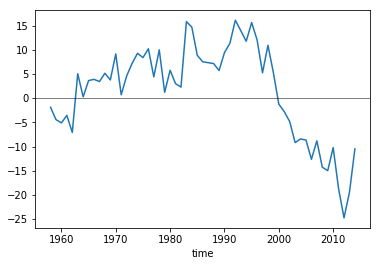

In [67]:
o2.plot()
plt.axhline(0,color='k',linewidth=0.5)